In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [2]:
%%time
# read train and test prepared in the notebook data_prep_4mod
train = pd.read_csv('data/train_numfeatures.csv.gz') 
test =  pd.read_csv('data/test_numfeatures.csv.gz')

CPU times: user 58.3 s, sys: 5.8 s, total: 1min 4s
Wall time: 1min 7s


Use sales with 'date_block_num' from 12 to 32 for modeling and sales with 'date_block_num'equal 33 for validation.
To train model for prediction on test, use sales with 'date_block_num' from 12 to 33

In [3]:
lag_var = ['tg', 'tg_sum', 'tg_mean', 'tg_shop', 'tg_item', 'tg_cat']

train = train[list(set(train) - set(lag_var))]
test = test[list(set(test) - set(lag_var))]

In [4]:
np.array(train.columns)

array(['tg_d3-2', 'tg_cat_d13-1', 'tg_item_d13-1', 'tg_d13-1',
       'tg_item_d2-1', 'tg_cat_lag2', 'tg_item_lag1', 'tg_shop_d13-1',
       'shop_id', 'tg_sum_d13-1', 'tg_item_d3-2', 'tg_item_lag2',
       'tg_lag2', 'tg_mean_lag13', 'tg_shop_lag13', 'tg_shop_lag2',
       'tg_item_lag12', 'tg_item_lag3', 'tg_mean_lag3', 'tg_mean_lag12',
       'tg_cat_lag1', 'tg_item_lag13', 'tg_shop_lag1', 'tg_lag3',
       'tg_lag12', 'tg_shop_lag3', 'tg_sum_lag13', 'tg_mean_d3-2',
       'tg_cat_d2-1', 'tg_cat_d3-2', 'tg_mean_lag2', 'tg_sum_lag1',
       'tg_sum_lag12', 'target', 'tg_cat_lag13', 'tg_cat_lag12',
       'nrow_block', 'tg_sum_d3-2', 'tg_sum_lag3', 'tg_mean_lag1',
       'tg_lag1', 'date_block_num', 'tg_shop_lag12', 'mean_price_l1',
       'tg_sum_d2-1', 'tg_cat_lag3', 'tg_mean_d2-1', 'item_id',
       'item_category_id', 'tg_d2-1', 'month', 'tg_shop_d2-1', 'tg_lag13',
       'tg_mean_d13-1', 'tg_sum_lag2', 'tg_shop_d3-2'], dtype=object)

In [4]:
# train, trainv and valid
train = train[train['date_block_num']>11]
trainv = train[train['date_block_num']!=33]
valid = train[train['date_block_num']==33]

lgbm with default hyperparameters on all features

[10]	training's rmse: 0.937465	valid_0's rmse: 0.963489
[20]	training's rmse: 0.883465	valid_0's rmse: 0.935607
[30]	training's rmse: 0.864807	valid_0's rmse: 0.931419
[40]	training's rmse: 0.854652	valid_0's rmse: 0.929683
[50]	training's rmse: 0.847016	valid_0's rmse: 0.929194
[60]	training's rmse: 0.840639	valid_0's rmse: 0.926276
[70]	training's rmse: 0.83645	valid_0's rmse: 0.925758
[80]	training's rmse: 0.832052	valid_0's rmse: 0.927843
[90]	training's rmse: 0.828355	valid_0's rmse: 0.9266
[100]	training's rmse: 0.824781	valid_0's rmse: 0.926257
CPU times: user 1min 34s, sys: 11.8 s, total: 1min 46s
Wall time: 23.6 s


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

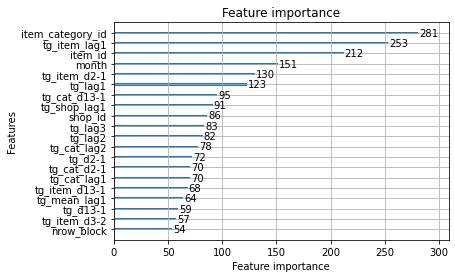

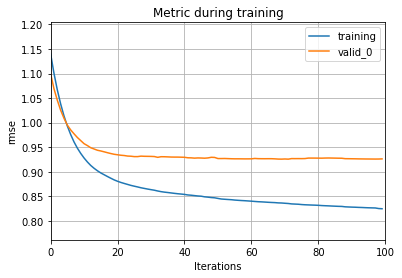

In [8]:
%%time
# Scikit-learn API (LGBMRegressor) is chosen as it's easier to build validation plot (in comparison with Training API)

X_train = trainv.drop('target', axis=1)
y_train = trainv['target']
X_valid = valid.drop('target', axis=1)
y_valid = valid['target']

model = lgb.LGBMRegressor(objective='rmse', n_estimators=100)
model.fit(X_train,
          y_train, 
          eval_set=[(X_valid, y_valid),(X_train,y_train)], 
          verbose=10  
        )

# plot feature importance and evaluation results
lgb.plot_importance(model, max_num_features=20);
lgb.plot_metric(model);


70 trees is optimal with default values of other hyperparameters, RMSE on valid is 0.9258

In [9]:
feature_imp = pd.DataFrame({'features':model.feature_name_, 'importance':model.feature_importances_}).sort_values('importance', ascending=False, ignore_index=True)
feature_imp

,features,importance
0,item_category_id,281
1,tg_item_lag1,253
2,item_id,212
3,month,151
4,tg_item_d2-1,130
5,tg_lag1,123
6,tg_cat_d13-1,95
7,tg_shop_lag1,91
8,shop_id,86
9,tg_lag3,83


mean encoding features with lag13 are less important that is expected, lag13 is useful for d13-1 calculation, wich is important for some mean encoding features
let's try modeling on 50 most important features and compare results

[10]	training's rmse: 0.937465	valid_0's rmse: 0.963489
[20]	training's rmse: 0.883465	valid_0's rmse: 0.935607
[30]	training's rmse: 0.864807	valid_0's rmse: 0.931419
[40]	training's rmse: 0.854482	valid_0's rmse: 0.930053
[50]	training's rmse: 0.847707	valid_0's rmse: 0.929827
[60]	training's rmse: 0.841995	valid_0's rmse: 0.930034
[70]	training's rmse: 0.8364	valid_0's rmse: 0.930894
[80]	training's rmse: 0.831857	valid_0's rmse: 0.930934
[90]	training's rmse: 0.828569	valid_0's rmse: 0.932477
[100]	training's rmse: 0.825578	valid_0's rmse: 0.932064
CPU times: user 1min 34s, sys: 10.1 s, total: 1min 44s
Wall time: 22.1 s


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

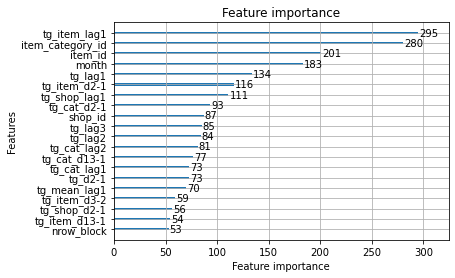

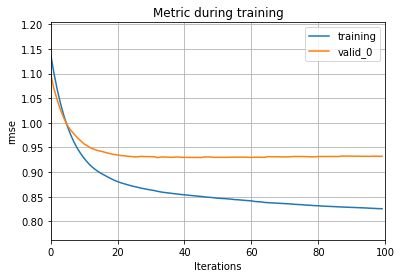

In [19]:
%%time

features50 = list(feature_imp.loc[:49,'features'].values)
X_train = trainv[features50]
y_train = trainv['target']
X_valid = valid[features50]
y_valid = valid['target']

model = lgb.LGBMRegressor(objective='rmse', n_estimators=100)
model.fit(X_train,
          y_train, 
          eval_set=[(X_valid, y_valid),(X_train,y_train)], 
          verbose=10  
        )

# plot feature importance and evaluation results
lgb.plot_importance(model, max_num_features=20);
lgb.plot_metric(model);

the result on less number of features is slightly worse, let's use all 55 features

let's try twice more trees (~140) and twice less learning (0.05)

[10]	training's rmse: 1.01664	valid_0's rmse: 1.01085
[20]	training's rmse: 0.939581	valid_0's rmse: 0.964773
[30]	training's rmse: 0.903526	valid_0's rmse: 0.945686
[40]	training's rmse: 0.88481	valid_0's rmse: 0.937435
[50]	training's rmse: 0.873353	valid_0's rmse: 0.932694
[60]	training's rmse: 0.865405	valid_0's rmse: 0.930233
[70]	training's rmse: 0.85917	valid_0's rmse: 0.929603
[80]	training's rmse: 0.854006	valid_0's rmse: 0.929321
[90]	training's rmse: 0.850093	valid_0's rmse: 0.928625
[100]	training's rmse: 0.846668	valid_0's rmse: 0.928562
[110]	training's rmse: 0.843607	valid_0's rmse: 0.927935
[120]	training's rmse: 0.840814	valid_0's rmse: 0.927319
[130]	training's rmse: 0.837833	valid_0's rmse: 0.927377
[140]	training's rmse: 0.835359	valid_0's rmse: 0.927053
[150]	training's rmse: 0.833367	valid_0's rmse: 0.927453
[160]	training's rmse: 0.830911	valid_0's rmse: 0.926889
[170]	training's rmse: 0.827988	valid_0's rmse: 0.928095
[180]	training's rmse: 0.826297	valid_0's rm

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

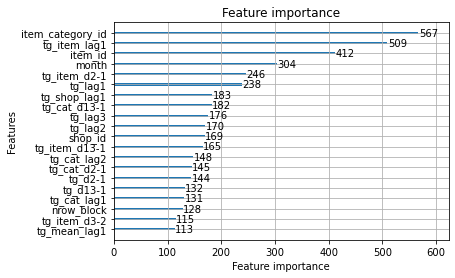

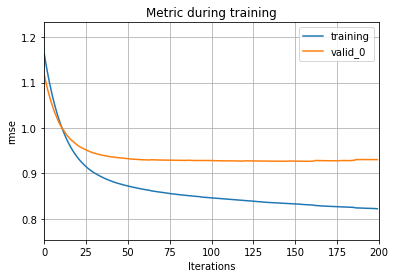

In [26]:
%%time

X_train = trainv.drop('target', axis=1)
y_train = trainv['target']
X_valid = valid.drop('target', axis=1)
y_valid = valid['target']

model = lgb.LGBMRegressor(objective='rmse', n_estimators=200, learning_rate=0.05)
model.fit(X_train,
          y_train, 
          eval_set=[(X_valid, y_valid),(X_train,y_train)], 
          verbose=10
        )

# plot feature importance and evaluation results
lgb.plot_importance(model, max_num_features=20);
lgb.plot_metric(model);

n_estimators=140, learning_rate=0.05 gives RMSE on valid 0.927
so, the best model so far is with 70 trees and default learning rate; let's try to add randomness

[10]	training's rmse: 0.937418	valid_0's rmse: 0.962749
[20]	training's rmse: 0.884941	valid_0's rmse: 0.936872
[30]	training's rmse: 0.865543	valid_0's rmse: 0.929911
[40]	training's rmse: 0.855545	valid_0's rmse: 0.932037
[50]	training's rmse: 0.848116	valid_0's rmse: 0.930912
[60]	training's rmse: 0.842663	valid_0's rmse: 0.930417
[70]	training's rmse: 0.837178	valid_0's rmse: 0.930966
[80]	training's rmse: 0.832899	valid_0's rmse: 0.930975
[90]	training's rmse: 0.828936	valid_0's rmse: 0.929917
[100]	training's rmse: 0.825705	valid_0's rmse: 0.931909
CPU times: user 1min 35s, sys: 11.4 s, total: 1min 47s
Wall time: 23.6 s


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

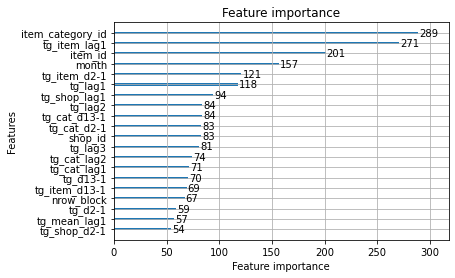

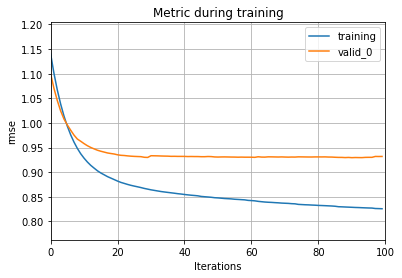

In [28]:
%%time

X_train = trainv.drop('target', axis=1)
y_train = trainv['target']
X_valid = valid.drop('target', axis=1)
y_valid = valid['target']

model = lgb.LGBMRegressor(objective='rmse', 
                          n_estimators=100, 
                          random_state=42,
                          colsample_bytree=0.9,
                          subsample=0.9)
model.fit(X_train,
          y_train, 
          eval_set=[(X_valid, y_valid),(X_train,y_train)], 
          verbose=10
        )

# plot feature importance and evaluation results
lgb.plot_importance(model, max_num_features=20);
lgb.plot_metric(model);

adding randomness didn't give  us any substantial improvement

let's build a model on train and predict on test

[10]	training's rmse: 0.938759
[20]	training's rmse: 0.886792
[30]	training's rmse: 0.867507
[40]	training's rmse: 0.857399
[50]	training's rmse: 0.849486
[60]	training's rmse: 0.843779
[70]	training's rmse: 0.8386
CPU times: user 1min 21s, sys: 11 s, total: 1min 32s
Wall time: 22.3 s


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

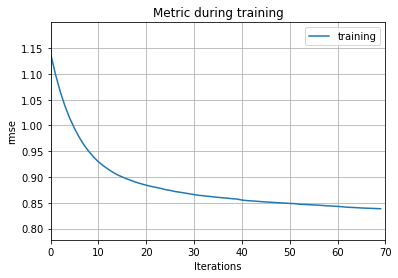

In [5]:
%%time

X_train = train.drop('target', axis=1)
y_train = train['target']

best_lgbm = lgb.LGBMRegressor(objective='rmse', n_estimators=70)
best_lgbm.fit(X_train,
          y_train, 
          eval_set=[(X_train,y_train)],
          verbose=10  
        )

# plot feature importance and evaluation results
# lgb.plot_importance(model, max_num_features=20);
lgb.plot_metric(best_lgbm);

In [35]:
test_init =  pd.read_csv('data/test.csv.gz')

In [36]:
y_pred = best_lgbm.predict(test).clip(min=0, max=20)
pd.DataFrame({'ID': test_init['ID'], 'item_cnt_month': y_pred}).to_csv("submissions/lgbm.csv", index=False)

RMSE on test on private/public leaderboard is 0.936/0.929 (133 place)

In [39]:
# best_lgbm.booster_.save_model('models/best_lgbm')

In [44]:
# bst = lgb.Booster(model_file='models/best_lgbm')

In [45]:
# y_pred = bst.predict(test).clip(min=0, max=20)

In [6]:
predontrain_lgb = best_lgbm.predict(X_train).clip(min=0, max=20)
pd.DataFrame({'lgb': predontrain_lgb}).to_csv("data/predontrain_lgb.csv", index=False)

In [7]:
print('rmse lgb:', np.sqrt(mean_squared_error(predontrain_lgb,y_train)))

rmse lgb: 0.8385849195301215
